## Strategies to Think about

- 1st derivative analysis of peaks to determine when to sell and buy
- Fast fourier transform to estimate harmonic osscilations in the market over short timespans
- Rolling averages, seem to be widely use
- Explore machine learning algorithms


### Important Terms to remember

- Drawdown:  typically quoted as the percentage difference between the peak of an investment and its following trough. It can be used to measure an investment's historical risk, compare the performance of different funds, or monitor a portfolio's performance.
- Slippage: the difference between the price you expected to enter a trade and the actual price at which your trade order was filled.

These two terms are different and measure different things, don't get them confused

### Things to be Aware of

Alpaca free API has a 15 minute delay in historical data. So data from 9:30am will be available at 9:45 am. This is important to consider in paper and live trading when testing an algorithm. Websockets can be used to get live data from alpaca. This will require storing the historical data from backtesting and then querying the websocket for up to date trading data.

In [1]:
# Standard Library Imports
from datetime import datetime, timedelta

# Third party Imports
import pytz
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.linalg import solve
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from scipy.optimize import minimize
from scipy.signal import savgol_filter

# Alpaca Imports
from alpaca.data.requests import CryptoBarsRequest, StockBarsRequest
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical import CryptoHistoricalDataClient, StockHistoricalDataClient

## Simulation Parameters for Fees and Slippage

In [2]:
# Based on the fees Alpaca has and verified in paper trading
crypto_fee = 0.005

# Assuming 1% for now until I can estimate it in paper trading
slippage =  0.005

investment = 100  # dollars
initial_investment = 100

ema_period = 7 # days
sma_period = 50 # days
rsi_period = 14 # days
adx_period = 14 # days

## Investment Data and information


In [3]:
# Time Specifications for data
resolution = 12  # minutes
time_frame = TimeFrame(resolution, TimeFrameUnit("Hour"))
time_length = 720 # days
start_time = datetime.now(pytz.utc) - timedelta(days=time_length)
end_time = datetime.now(pytz.utc)
 
symbols = ["BTC/USD"]

## API call for current and historic data


In [15]:
# Time Specifications for data
resolution = 1  # minutes
time_frame = TimeFrame(resolution, TimeFrameUnit("Day"))
time_length = 720 # days
start_time = datetime.now(pytz.utc) - timedelta(days=time_length)
end_time = datetime.now(pytz.utc) - timedelta(days=1)

stocks_symbols = ["SPY"]

# No keys required for crypto data
client = StockHistoricalDataClient(
    api_key="PKNKGCDY6BJABXQ6C9BE",
    secret_key="D2Tt8UKtISVgmaBDZS5mLbZeidk0gh7wDYpVS6M4",
)

# Creating request object
request_params = StockBarsRequest(
    symbol_or_symbols=stocks_symbols,
    timeframe=time_frame,
    start=start_time,
    end=end_time,
    adjustment="all",
)

# Retrieve daily bars for Bitcoin in a DataFrame and printing it
stock_bars = client.get_stock_bars(request_params)

# Convert to dataframe
stock_data = stock_bars.df.reset_index()
# stock_data.to_csv(r"C:\Users\zhatz\Documents\GitHub\Data-Science-Masters\Mathematics of Finance\Final_project_stock_data.csv", index=False)
stock_data

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,SPY,2023-07-28 04:00:00+00:00,444.04,445.8900,440.7400,445.05,80011791.0,528395.0,444.760000
1,SPY,2023-07-31 04:00:00+00:00,445.53,446.2600,444.2000,445.90,62040450.0,438677.0,445.210000
2,SPY,2023-08-01 04:00:00+00:00,444.42,445.3800,443.6600,444.63,55502201.0,418014.0,444.530000
3,SPY,2023-08-02 04:00:00+00:00,441.48,441.7400,437.6800,438.44,93933371.0,622259.0,439.370000
4,SPY,2023-08-03 04:00:00+00:00,436.40,439.0800,435.7500,437.18,64928592.0,486817.0,437.460000
...,...,...,...,...,...,...,...,...,...
487,SPY,2025-07-09 04:00:00+00:00,622.77,624.7200,620.9105,624.06,66113326.0,735000.0,622.946884
488,SPY,2025-07-10 04:00:00+00:00,624.20,626.8701,623.0100,625.82,57527933.0,648814.0,625.358699
489,SPY,2025-07-11 04:00:00+00:00,622.74,624.8600,621.5300,623.62,63670226.0,748955.0,623.809901
490,SPY,2025-07-14 04:00:00+00:00,623.16,625.1581,621.7999,624.81,51898518.0,626509.0,623.953909


,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,AMZN,2023-07-27 04:00:00+00:00,131.000,132.630,127.7900,128.25,52615264.0,499613.0,130.435236
1,AMZN,2023-07-28 04:00:00+00:00,129.690,133.010,129.3300,132.21,46317383.0,413443.0,131.926664
2,AMZN,2023-07-31 04:00:00+00:00,133.200,133.870,132.3800,133.68,46096810.0,406716.0,133.368468
3,AMZN,2023-08-01 04:00:00+00:00,133.550,133.690,131.6199,131.69,42330577.0,386249.0,132.227432
4,AMZN,2023-08-02 04:00:00+00:00,130.154,130.230,126.8200,128.21,51058784.0,533321.0,128.371877
...,...,...,...,...,...,...,...,...,...
1963,PLTR,2025-07-08 04:00:00+00:00,138.775,139.855,135.7900,139.71,59834823.0,588182.0,138.073282
1964,PLTR,2025-07-09 04:00:00+00:00,139.655,143.170,137.3900,143.13,68494760.0,653002.0,140.504119
1965,PLTR,2025-07-10 04:00:00+00:00,143.310,145.160,139.5300,142.50,64383766.0,705080.0,142.123587
1966,PLTR,2025-07-11 04:00:00+00:00,142.110,144.580,141.4700,142.10,52134812.0,543697.0,143.105371


In [9]:
for group, data in stock_data.groupby("symbol"):
    print(len(data))
    print(f"Symbol: {group}, data: {data.iloc[0]}")

492
Symbol: AAPL, data: symbol                              AAPL
timestamp      2023-07-27 04:00:00+00:00
open                              196.02
high                               197.2
low                               192.55
close                             193.22
volume                        47465977.0
trade_count                     570678.0
vwap                          194.950386
Name: 984, dtype: object
492
Symbol: AMZN, data: symbol                              AMZN
timestamp      2023-07-27 04:00:00+00:00
open                               131.0
high                              132.63
low                               127.79
close                             128.25
volume                        52615264.0
trade_count                     499613.0
vwap                          130.435236
Name: 0, dtype: object
492
Symbol: LLY, data: symbol                               LLY
timestamp      2023-07-27 04:00:00+00:00
open                              453.32
high                

In [4]:
# No keys required for crypto data
client = CryptoHistoricalDataClient()

# Creating request object
request_params = CryptoBarsRequest(
    symbol_or_symbols=symbols,
    timeframe=time_frame,
    start=start_time,
    end=end_time,
)

# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)

# Convert to dataframe
btc_data = btc_bars.df.reset_index()
btc_data = btc_data.set_index("timestamp")
btc_data["Drawdown"] = 100*(btc_data["low"] - btc_data["high"])/btc_data["high"]
btc_data["EMA"] = btc_data["close"].ewm(halflife=timedelta(days=ema_period), times=btc_data.index).mean()
btc_data["SMA"] = btc_data["close"].rolling(f"{int(sma_period)}D").mean()

def calculate_rsi(window):
    # Difference in closing prices
    diff = np.diff(window)

    # Gains and losses
    gains = np.where(diff > 0, diff, 0)
    losses = np.where(diff < 0, -diff, 0)  # take abs(losses)

    avg_gain = np.mean(gains)
    avg_loss = np.mean(losses)

    # Avoid division by zero
    if avg_loss == 0:
        return 100.0  # Max RSI
    elif avg_gain == 0:
        return 0.0    # Min RSI

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

btc_data["RSI"] = btc_data["close"].rolling(window=rsi_period).apply(calculate_rsi, raw=True)


def calculate_adx(df, period=14):
    high = df['high']
    low = df['low']
    close = df['close']

    # Calculate True Range (TR)
    df['TR'] = np.maximum.reduce([
        high - low,
        (high - close.shift()).abs(),
        (low - close.shift()).abs()
    ])

    # Calculate Directional Movement (+DM and -DM)
    df['+DM'] = np.where((high - high.shift()) > (low.shift() - low), 
                         np.maximum(high - high.shift(), 0), 0)
    df['-DM'] = np.where((low.shift() - low) > (high - high.shift()), 
                         np.maximum(low.shift() - low, 0), 0)

    # Smooth TR, +DM, -DM
    tr_smooth = df['TR'].rolling(window=period).sum()
    plus_dm_smooth = df['+DM'].rolling(window=period).sum()
    minus_dm_smooth = df['-DM'].rolling(window=period).sum()

    # Calculate +DI and -DI
    df['+DI'] = 100 * (plus_dm_smooth / tr_smooth)
    df['-DI'] = 100 * (minus_dm_smooth / tr_smooth)

    # Calculate DX
    df['DX'] = 100 * (df['+DI'] - df['-DI']).abs() / (df['+DI'] + df['-DI'])

    # Calculate ADX
    df['ADX'] = df['DX'].rolling(window=period).mean()

    return df

btc_data = calculate_adx(btc_data, period=adx_period)


btc_data = btc_data.reset_index()
btc_data

,timestamp,symbol,open,high,low,close,volume,trade_count,vwap,Drawdown,EMA,SMA,RSI,TR,+DM,-DM,+DI,-DI,DX,ADX
0,2023-07-27 00:00:00+00:00,BTC/USD,29351.354244,29623.665730,29286.650000,29507.426222,2.108205,44.0,29544.796421,-1.137657,29507.426222,29507.426222,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,2023-07-27 12:00:00+00:00,BTC/USD,29506.617737,29534.383000,29087.095810,29223.784910,0.485039,75.0,29257.512161,-1.514463,29362.095476,29365.605566,NaN,447.287190,0.000000,199.554190,NaN,NaN,NaN,NaN
2,2023-07-28 00:00:00+00:00,BTC/USD,29225.310000,29419.494670,29120.062867,29213.849903,0.696490,27.0,29278.929153,-1.017801,29310.214537,29315.020345,NaN,299.431803,0.000000,0.000000,NaN,NaN,NaN,NaN
3,2023-07-28 12:00:00+00:00,BTC/USD,29209.949253,29535.353100,29192.732500,29317.230286,0.519581,71.0,29385.149524,-1.160036,29312.100799,29315.572830,NaN,342.620600,115.858430,0.000000,NaN,NaN,NaN,NaN
4,2023-07-29 00:00:00+00:00,BTC/USD,29315.672947,29419.874869,29263.950134,29278.029685,0.080300,15.0,29366.182627,-0.529998,29304.595697,29308.064201,NaN,155.924735,0.000000,0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,2025-07-13 12:00:00+00:00,BTC/USD,118131.000000,119454.693655,118068.200000,119110.540000,0.425469,178.0,119155.071872,-1.160686,110738.314519,107415.721225,90.194514,1386.493655,1282.285655,0.000000,45.998197,5.118555,79.973081,50.462183
1436,2025-07-14 00:00:00+00:00,BTC/USD,119157.685500,123207.289500,118953.640000,121472.600000,1.606520,269.0,120895.526077,-3.452433,111256.832536,107557.607390,93.940126,4253.649500,3752.595845,0.000000,53.337769,4.575717,84.198095,55.469147
1437,2025-07-14 12:00:00+00:00,BTC/USD,121480.565000,122180.700000,119239.709000,119880.798000,2.214274,470.0,120421.727790,-2.407083,111673.411868,107665.719970,84.469893,2940.991000,0.000000,0.000000,50.322482,0.842351,96.707306,61.813571
1438,2025-07-15 00:00:00+00:00,BTC/USD,119826.375000,119948.650000,116321.978818,117144.230000,1.100747,127.0,117408.470181,-3.023520,111937.678901,107738.886715,71.920146,3626.671182,0.000000,2917.730182,46.272140,9.427597,66.148506,65.369854


In [11]:
len(btc_data)

1440

In [12]:
len(btc_data.dropna())

1413

In [5]:
btc_data.loc[0, "close"]

np.float64(29189.663674725)

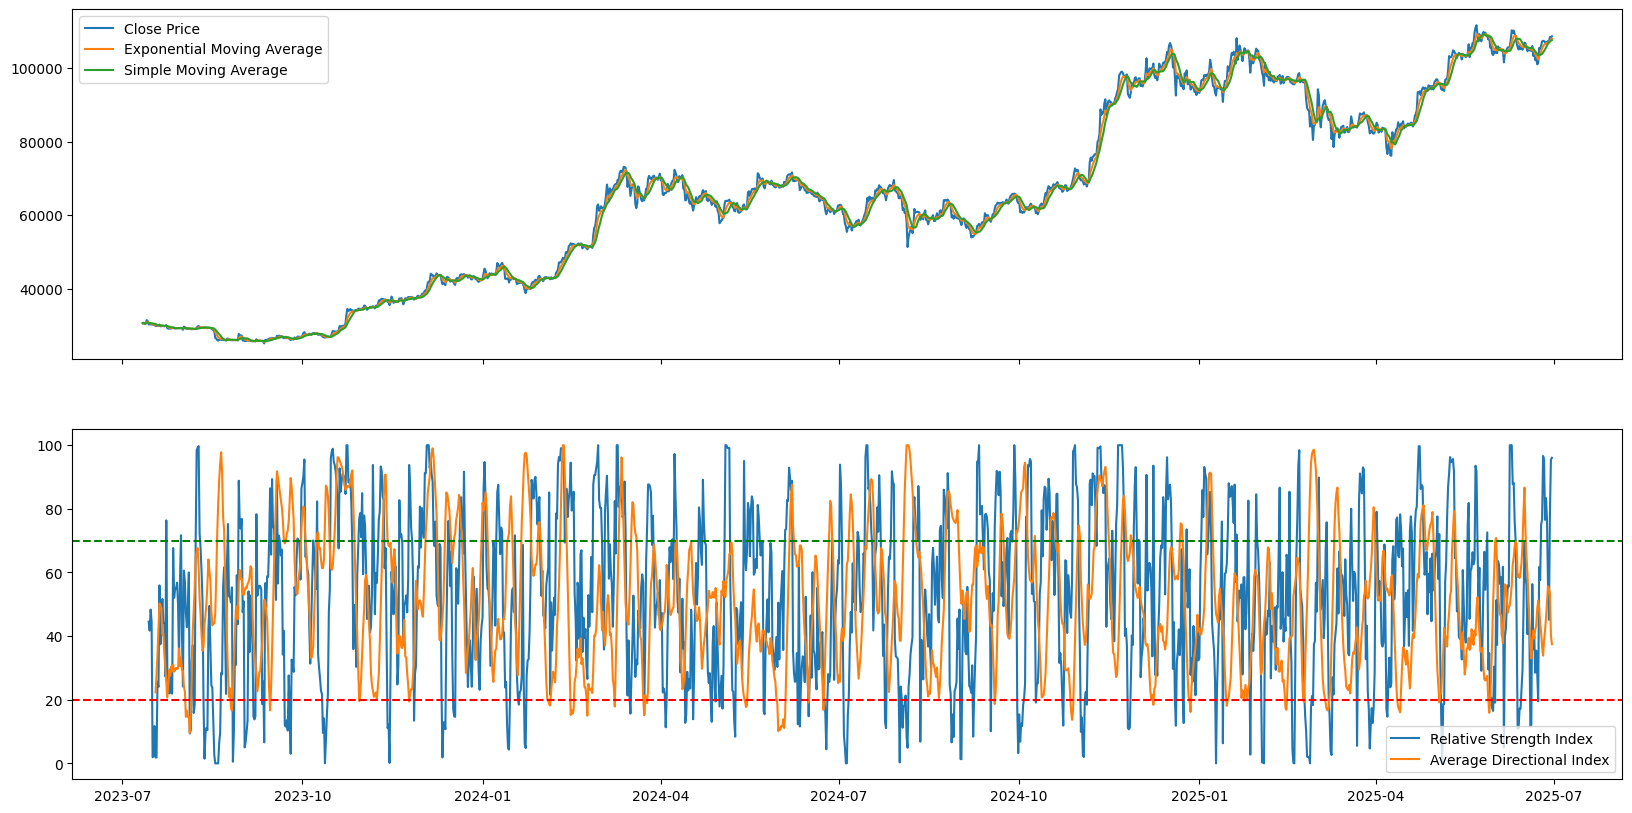

In [217]:
# Create a figure and the primary axes
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True)

ax[0].plot(btc_data["timestamp"], btc_data["close"], label="Close Price")
ax[0].plot(btc_data["timestamp"], btc_data["EMA"], label="Exponential Moving Average")
ax[0].plot(btc_data["timestamp"], btc_data["SMA"], label="Simple Moving Average")
ax[0].legend()

ax[1].plot(btc_data["timestamp"], btc_data["RSI"], label="Relative Strength Index")
ax[1].plot(btc_data["timestamp"], btc_data["ADX"], label="Average Directional Index")
ax[1].axhline(70, linestyle="--", color="g")
ax[1].axhline(20, linestyle="--", color="r")
ax[1].legend()

## MARSdx BTCUSD Strategy

In [218]:
indictors = [rsi_period, adx_period]
start_point = np.max(indictors)

def mars_dx(
        data: pd.DataFrame, 
        investment, 
        slippage, 
        fees,
        win_len,
    ):
    orders_dict = {}
    current_key = 0
    has_position = False

    most_profitable_trade_datetime = ""
    most_profitable_trade_amount = -np.inf

    most_unprofitable_trade_datetime = ""
    most_unprofitable_trade_amount = np.inf
    equity_curve = []

    for idx in range(win_len, len(data)):

        row = data.iloc[idx, :]

        if (
            (row["close"] > row["SMA"])
            and (row["close"] > row["EMA"])
            and (row["RSI"] > row["ADX"])
            and not has_position
        ):
            has_position = True
            orders_dict[current_key] = {
                "Order Index": idx,
                "Order Datetime": row["timestamp"],
                "Order Price": row["close"]*(1+slippage),
                "Buy Close Price": row["close"],
                "Buy SMA": row["SMA"],
                "Buy EMA": row["EMA"],
                "Buy RSI": row["RSI"],
                "Buy ADX": row["ADX"],
                "Profit": 0,
                "Sell Price": np.nan,
            }

        if has_position:
            if (
                row["RSI"] < row["ADX"]
                and (row["close"] < row["EMA"])
            ):
                orders_dict[current_key]["Sell Datetime"] = row["timestamp"]
                orders_dict[current_key]["Sell Price"] = row["close"]*(1-slippage)
                orders_dict[current_key]["Percent Change"] = (
                    100
                    * (orders_dict[current_key]["Sell Price"] - orders_dict[current_key]["Order Price"])
                    / orders_dict[current_key]["Order Price"]
                )
                orders_dict[current_key]["Profit"] = (
                    orders_dict[current_key]["Percent Change"] * investment / 100
                )*(1-(fees))
                investment += orders_dict[current_key]["Profit"]

                if orders_dict[current_key]["Profit"] > most_profitable_trade_amount:
                    most_profitable_trade_amount = orders_dict[current_key]["Profit"]
                    most_profitable_trade_datetime = orders_dict[current_key][
                        "Order Datetime"
                    ]
                if orders_dict[current_key]["Profit"] < most_unprofitable_trade_amount:
                    most_unprofitable_trade_amount = orders_dict[current_key]["Profit"]
                    most_unprofitable_trade_datetime = orders_dict[current_key][
                        "Order Datetime"
                    ]
                
                orders_dict[current_key]["Sell Close Price"] = row["close"]
                orders_dict[current_key]["Sell SMA"] = row["SMA"]
                orders_dict[current_key]["Sell EMA"] = row["EMA"]
                orders_dict[current_key]["Sell RSI"] = row["RSI"]
                orders_dict[current_key]["Sell ADX"] = row["ADX"]

                has_position = False
                if orders_dict[current_key]["Profit"] != 0:
                    current_key += 1
                equity_curve.append(investment)

    trade_metrics = [
        most_profitable_trade_datetime,
        most_profitable_trade_amount,
        most_unprofitable_trade_datetime,
        most_unprofitable_trade_amount,
    ]
    return orders_dict, trade_metrics, investment, equity_curve


orders_dict, trade_metrics, investment, equity_curve = mars_dx(
    btc_data, investment, slippage=slippage, fees=crypto_fee, win_len=start_point
)

profit_array = np.array([value["Profit"] for _, value in orders_dict.items()])
total_profit = investment - initial_investment
profit_per_day = (investment - initial_investment) / time_length
percent_profit_per_day = total_profit / initial_investment / time_length

win_rate = 100*len(np.where(profit_array>0)[0])/len(np.where(profit_array<0)[0])
profit_factor = np.sum(profit_array[np.where(profit_array>0)[0]])/np.sum(np.abs(profit_array[np.where(profit_array<0)[0]]))
return_array = np.array([(value["Sell Price"] - value["Order Price"])/value["Order Price"] for _, value in orders_dict.items()])
sharpe_ratio = (np.nanmean(return_array)-0.02)/np.nanstd(return_array)
sortino_ratio = (np.nanmean(return_array)-0.02)/np.nanstd(return_array[np.where(return_array<0)[0]])
pw = len(np.where(profit_array>0)[0])/len(profit_array)
aw = np.mean(profit_array[np.where(profit_array>0)[0]])
pl = len(np.where(profit_array<0)[0])/len(profit_array)
al = np.mean(profit_array[np.where(profit_array<0)[0]])
expectancy = (pw*aw) - (pl*al)

def max_drawdown(equity_curve):
    peak = equity_curve[0]
    max_dd = 0
    for value in equity_curve:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        max_dd = max(max_dd, drawdown)
    return max_dd

trade_summary = {
    'Total Trades': len(orders_dict),
    'Win Rate': np.round(win_rate, decimals=2),
    'CAGR': 18.2,
    'Sharpe Ratio': sharpe_ratio,
    'Sortino Ratio': sortino_ratio,
    'Max Drawdown': -max_drawdown(equity_curve),
    'Profit Factor': np.round(profit_factor, decimals=2),
    'Average Trade Duration': '3.2 hours',
    'Expectancy': expectancy,
    "Profit/Day": profit_per_day,
    "Percent Profit/Day": 100 * percent_profit_per_day,
    "Total Profit": total_profit, 
    "Final Investment": investment,
}

trade_summary
# print("Trading Results Summary")
# print("------------------------------")
# print(f"Total Profit: ${total_profit:,.2f}")
# print(f"Profit/Day: ${profit_per_day:,.2f}")
# print(f"Percent Profit/Day: {100 * percent_profit_per_day:,.3f}%")
# print(f"Final Investment: ${investment:,.2f}")
# print("------------------------------")
# print(
#     f"Most Profitable Trade: ${trade_metrics[1]:,.2f}, Order Date: {trade_metrics[0]}"
# )
# print(
#     f"Most Un-Profitable Trade: ${trade_metrics[3]:,.2f}, Order Date: {trade_metrics[2]}"
# )

{'Total Trades': 79,
 'Win Rate': np.float64(56.0),
 'CAGR': 18.2,
 'Sharpe Ratio': np.float64(-0.15658461588118244),
 'Sortino Ratio': np.float64(-0.6188758277116918),
 'Max Drawdown': np.float64(-0.3423581081166162),
 'Profit Factor': np.float64(1.11),
 'Average Trade Duration': '3.2 hours',
 'Expectancy': np.float64(0.6028117296541988),
 'Profit/Day': np.float64(-0.11985464298579222),
 'Percent Profit/Day': np.float64(-0.11985464298579222),
 'Total Profit': np.float64(-86.2953429497704),
 'Final Investment': np.float64(13.704657050229605)}

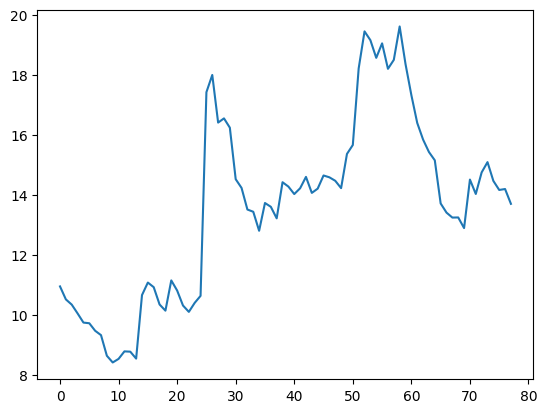

In [220]:
plt.plot(equity_curve)

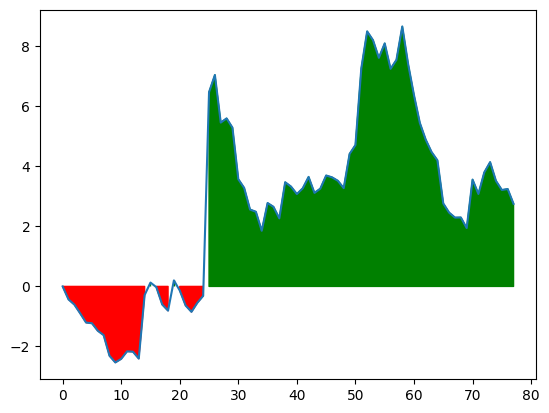

In [221]:
test = np.cumsum(np.diff(equity_curve))
new_test = np.insert(test, 0, 0)
x = np.arange(0, len(new_test), 1)
plt.plot(new_test)
plt.fill_between(x, new_test, 0, where=(new_test > 0), color='green')
plt.fill_between(x, new_test, 0, where=(new_test <= 0), color='red')

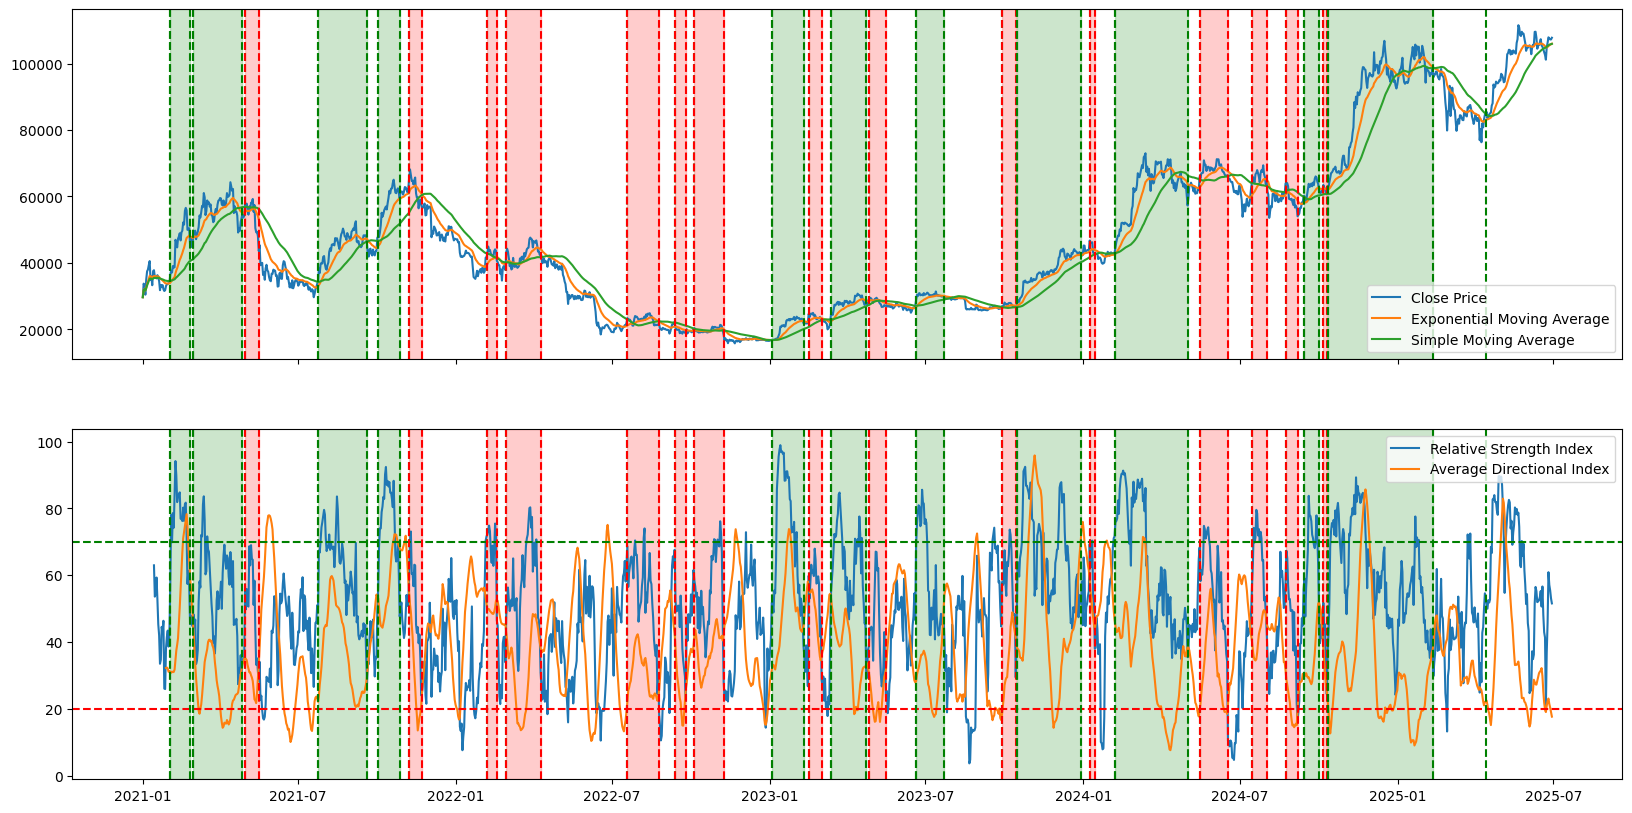

In [135]:
# Create a figure and the primary axes
alpha_=0.2
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True)

ax[0].plot(btc_data["timestamp"], btc_data["close"], label="Close Price")
ax[0].plot(btc_data["timestamp"], btc_data["EMA"], label="Exponential Moving Average")
ax[0].plot(btc_data["timestamp"], btc_data["SMA"], label="Simple Moving Average")
ax[0].legend()

ax[1].plot(btc_data["timestamp"], btc_data["RSI"], label="Relative Strength Index")
ax[1].plot(btc_data["timestamp"], btc_data["ADX"], label="Average Directional Index")
ax[1].axhline(70, linestyle="--", color="g")
ax[1].axhline(20, linestyle="--", color="r")
ax[1].legend()

for key, value in orders_dict.items():
    ax[0].axvline(value["Order Datetime"], linestyle="--", color="green")
    ax[1].axvline(value["Order Datetime"], linestyle="--", color="green")
    try:
        if value["Profit"] > 0:
            ax[0].axvspan(value["Order Datetime"], value["Sell Datetime"], alpha=alpha_, color='green')
            ax[0].axvline(value["Order Datetime"], linestyle="--", color="green")
            ax[0].axvline(value["Sell Datetime"], linestyle="--", color="green")

            ax[1].axvspan(value["Order Datetime"], value["Sell Datetime"], alpha=alpha_, color='green')
            ax[1].axvline(value["Order Datetime"], linestyle="--", color="green")
            ax[1].axvline(value["Sell Datetime"], linestyle="--", color="green")
        else:
            ax[0].axvspan(value["Order Datetime"], value["Sell Datetime"], alpha=alpha_, color='red')
            ax[0].axvline(value["Order Datetime"], linestyle="--", color="red")
            ax[0].axvline(value["Sell Datetime"], linestyle="--", color="red")

            ax[1].axvspan(value["Order Datetime"], value["Sell Datetime"], alpha=alpha_, color='red')
            ax[1].axvline(value["Order Datetime"], linestyle="--", color="red")
            ax[1].axvline(value["Sell Datetime"], linestyle="--", color="red")
    except KeyError:
        pass


### Strategy Optimization of Indicator Periods

Try to avoid overfitting that maximizes profit factor and minizmizes the drawdown.